# Homework 8

In this homework, we will explore boosting and investigate how it performs on two datasets with two different weak learnings. First, let us look at the spiral dataset with decision stumps as the weak learning. Then, we will implement and explore the Viola-Jones face detector features as weak classifiers with AdaBoost.

There are a number of programming **tasks** and **quiz questions** in this homework.
- For **tasks**, you will need to either **add code between comments "`#### TASK N CODE`"** to complete them or **modify code between those comments**. **DO NOT delete the comments "#### TASK N CODE". This is for graders' reference and you might not get full points if you tamper with these comments.**
- For **quiz questions**, you will need to answer in a few sentences between the given lines.
- For **optional tasks**, you are **NOT required to turn them in**. However, we encourage you to complete them as they are good practice.
- For **challenge-optional tasks**, you are **NOT required to turn them in**. However, you will receive extra credit for completing the challenge.

## Preliminaries

In [3]:
!wget -O utils.py https://www.dropbox.com/scl/fi/m3v7lwkxssqo77x5b92zc/utils.py?rlkey=rm9ane55csq5tqga54w394zo8

--2025-02-27 13:44:18--  https://www.dropbox.com/scl/fi/m3v7lwkxssqo77x5b92zc/utils.py?rlkey=rm9ane55csq5tqga54w394zo8
Resolving www.dropbox.com (www.dropbox.com)... 2620:100:6018:18::a27d:312, 162.125.3.18
Connecting to www.dropbox.com (www.dropbox.com)|2620:100:6018:18::a27d:312|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc1d6c4cfb7b26c23b5f3198a9e7.dl.dropboxusercontent.com/cd/0/inline/Ck8ucC-e6YUdLzB-T8XUj0yAyWmE7bYe7b7VqzSgLpSbHjZZf1D6g-psPmVlRxEsJexeBAI-IVdJvYam7byMyqRtrm-EX80jKE562qg6BfPY1odbjHlRd95vPpotZ2GGw34S14fb7EV3GnU2JThDDweV/file# [following]
--2025-02-27 13:44:19--  https://uc1d6c4cfb7b26c23b5f3198a9e7.dl.dropboxusercontent.com/cd/0/inline/Ck8ucC-e6YUdLzB-T8XUj0yAyWmE7bYe7b7VqzSgLpSbHjZZf1D6g-psPmVlRxEsJexeBAI-IVdJvYam7byMyqRtrm-EX80jKE562qg6BfPY1odbjHlRd95vPpotZ2GGw34S14fb7EV3GnU2JThDDweV/file
Resolving uc1d6c4cfb7b26c23b5f3198a9e7.dl.dropboxusercontent.com (uc1d6c4cfb7b26c23b5f3198a9e7.dl.dropboxusercontent.com)... 2620:100:6

In [4]:
from typing import Optional

import numpy as np
import matplotlib.pyplot as plt
from skimage import io, transform

import utils

In [5]:
SEED = 0
np.random.seed(SEED)

## [Task 1] Implementation of AdaBoost
Here, we implement AdaBoost. Add line numbers (`ctrl`+ m + l).
1. Implement the distribution update in the `fit` method.
2. Implement the `predict` method.

In [6]:
class AdaBoost:
    def __init__(
        self,
        base_learner,
        n_learners: int = 50,
        sample_size: Optional[int] = None,
        **base_learner_kwargs
    ):
        '''
        Boost base_learners for up to n_learners times.

        Args:
            base_learner: Class of weak learner, must support sample weighting as
                .fit(X, y, sample_weight=D) if sample_size is set to None (subsampling
                disabled), and .predict(X).
            n_learners: (default 50) Maximum number of weak learners to fit.
            sample_size: (default None) Number of samples drawn for fitting each weak
                leaner. The samples are drawn according to the distribution D^{(t)}
                and then fit rather than fitting by weighing samples according to the
                distribution. Data is subsampled if not None, else it is weighed.
        '''
        self.base_learner = base_learner
        self.n_learners = n_learners
        self.sample_size = sample_size
        self.base_learner_kwargs = base_learner_kwargs

        self.learned_clfs = []
        self.learned_clfs_alphas = []

    def fit(self, X: np.ndarray, y: np.ndarray):
        '''
        Fits base learners using AdaBoost algorithm.

        Args:
            X: Data features. shape (m, d)
            y: Data labels, must be binary +/-1. shape (m)
        '''
        assert X.shape[0] == y.shape[0]

        self.learned_clfs = []
        self.learned_clfs_alphas = []

        m = X.shape[0]
        D = np.ones(m) / m

        for t in range(self.n_learners):
            # Instantiate a base learner
            clf = self.base_learner(**self.base_learner_kwargs)

            # Fit the learner
            if self.sample_size is not None:
                # Subsample from X and y using weights D
                sample_idxs = np.random.choice(m, self.sample_size, replace=True, p=D)
                clf.fit(X[sample_idxs], y[sample_idxs])
            else:
                # Use D as sample_weight when fitting
                clf.fit(X, y, sample_weight=D)

            # Get coefficient for fitted learner
            y_pred = clf.predict(X)
            eps_t = utils.empirical_err(y, y_pred, sample_weight=D)

            if np.isclose(eps_t, 0.5):
                # Adding this classifier does not help
                break
            elif np.isclose(eps_t, 0.):
                # Achieved classifier that fits fully
                alpha_t = 1.
                self.learned_clfs.append(clf)
                self.learned_clfs_alphas.append(alpha_t)
                break
            else:
                alpha_t = (np.log(1 - eps_t) - np.log(eps_t)) / 2

            #### TASK 1 CODE
            # Update D according to alpha_t
            D = D * np.exp(-alpha_t * y * y_pred)
            D = D / np.sum(D)
            #### TASK 1 CODE

            # Record classifier and alpha_t
            self.learned_clfs.append(clf)
            self.learned_clfs_alphas.append(alpha_t)

    def predict(self, X: np.ndarray):
        '''
        Returns predictions for data.

        Args:
            X: Data features. shape (n)

        Returns:
            shape (n), binary vector of +/-1.
        '''
        assert len(self.learned_clfs) > 0, 'Classifier not trained!'

        #### TASK 1 CODE
        pred = 0
        for clf, alpha in zip(self.learned_clfs, self.learned_clfs_alphas):
            pred += alpha * clf.predict(X)
        return np.sign(pred)
        #### TASK 1 CODE



Now, let us generate spiral data similar to that in the second homework and visualize it.

In [7]:
LABELS = [-1, 1]
SP_THETA_SIGMA = 0.15
SP_R_SIGMA = 0.04

m = 5000
Xsp, ysp = utils.generate_spiral_data(m, noise_level=0.08, theta_sigma=SP_THETA_SIGMA, r_sigma=SP_R_SIGMA)

In [8]:
def scatter_plot(X, y, **plot_kwargs):
    plt.figure(figsize=(8, 6))
    for i, l in enumerate(LABELS):
        l_idxs = np.where(y == l)
        plt.scatter(X[l_idxs, 0], X[l_idxs, 1], label=l, c=utils.cmap_fg[i], **plot_kwargs)
    plt.xlabel('$x_1$') # matplotlib allows basic latex in rendered text!
    plt.ylabel('$x_2$')
    plt.legend(title='label')


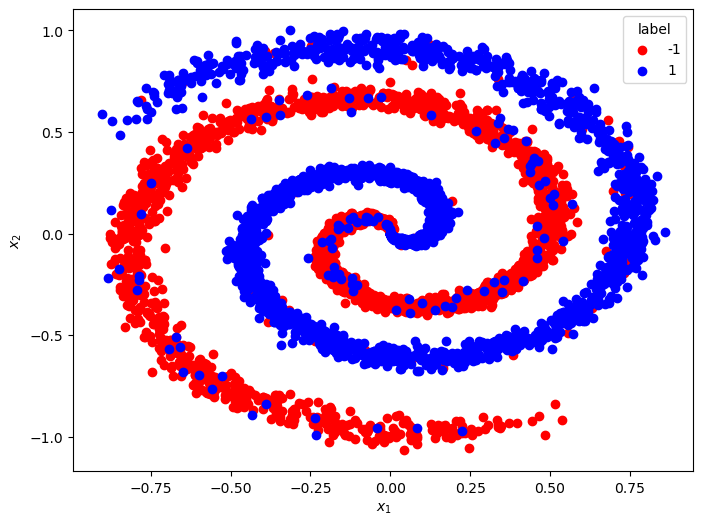

In [9]:
scatter_plot(Xsp, ysp)

In [10]:
train_test_ratio = 0.8
Xsp_train, ysp_train, Xsp_test, ysp_test = utils.create_split(Xsp, ysp, train_test_ratio)

### Running AdaBoost with Decision Stumps

Now, we can play around with how AdaBoost performs on the spiral data when using decision stumps as the weak classifier. Note that there are two different interfaces with which you can use `AdaBoost`

In [11]:
from sklearn.tree import DecisionTreeClassifier

# AdaBoost with sample weighting
boosted_clf = AdaBoost(DecisionTreeClassifier, n_learners=100, max_depth=1)
boosted_clf.fit(Xsp_train, ysp_train)

ysp_train_predict = boosted_clf.predict(Xsp_train)
train_err = utils.empirical_err(ysp_train, ysp_train_predict)

print(f'Train error: {train_err*100:0.2f}%')

ysp_test_predict = boosted_clf.predict(Xsp_test)
test_err = utils.empirical_err(ysp_test, ysp_test_predict)

print(f'Test error: {test_err*100:0.2f}%')

Train error: 11.53%
Test error: 11.70%


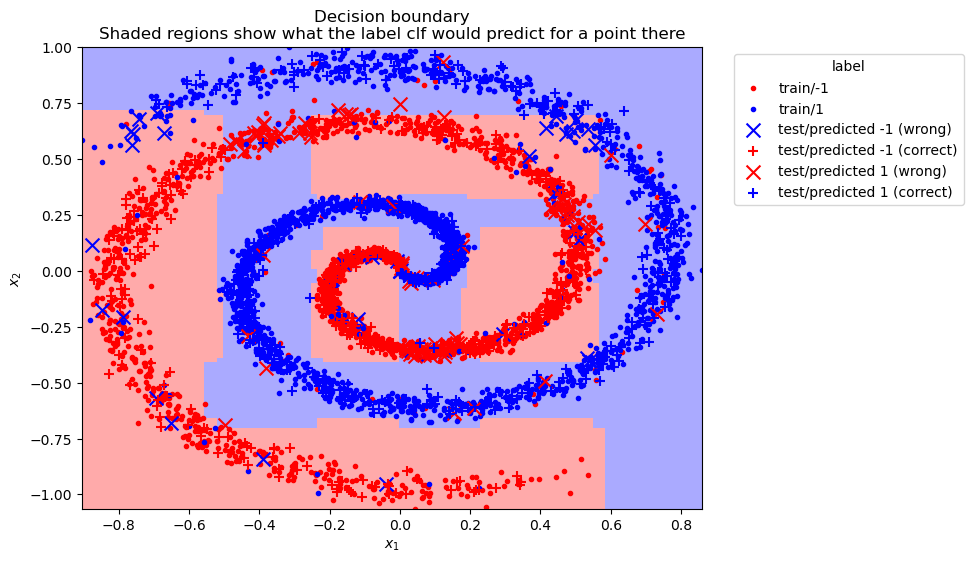

In [12]:
utils.plot_decision_boundary(boosted_clf, Xsp_train, ysp_train, Xsp_test, ysp_test)

In [13]:
from sklearn.tree import DecisionTreeClassifier

np.random.seed(300)
# AdaBoost with subsampling
boosted_clf = AdaBoost(DecisionTreeClassifier, n_learners=100, sample_size=1000, max_depth=1)
boosted_clf.fit(Xsp_train, ysp_train)

ysp_train_predict = boosted_clf.predict(Xsp_train)
train_err = utils.empirical_err(ysp_train, ysp_train_predict)

print(f'Train error: {train_err*100:0.2f}%')

ysp_test_predict = boosted_clf.predict(Xsp_test)
test_err = utils.empirical_err(ysp_test, ysp_test_predict)

print(f'Test error: {test_err*100:0.2f}%')

Train error: 9.43%
Test error: 9.00%


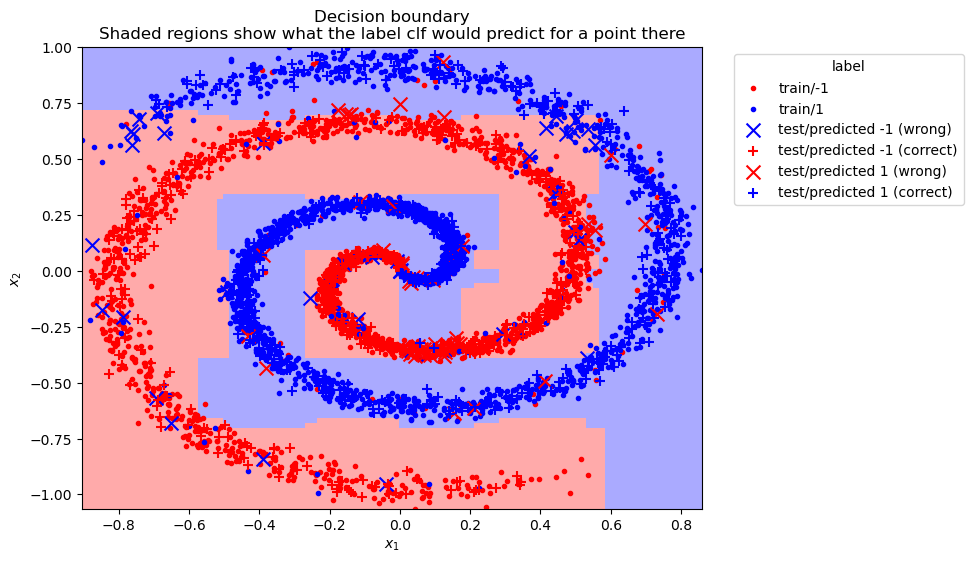

In [14]:
utils.plot_decision_boundary(boosted_clf, Xsp_train, ysp_train, Xsp_test, ysp_test)

## Viola Jones and Boosting
In this part, let us build a classifier based on the Viola-Jones framework for determining whether or not a picture has a face in it.

Objectives for this section are:
* understanding the feature extraction and weak classifier training procedures.
* training a strong classifier using Boosting.
* investigating the strong classifier using Boosting

For data, we need both positive examples (examples with faces) and negative examples (examples without faces). For the positive samples, we use the training set of [Faces in the Wild](http://vis-www.cs.umass.edu/lfw/). This is a collection of images of celebrities matched with their names for use in tasks like face identification. The negative samples arise from the dog class from [Common Objects in Context](https://cocodataset.org/) (COCO). Let us first explore the dataset.

In [19]:
# !mkdir    data
# !wget -O  data/faces_selected.zip https://www.dropbox.com/scl/fi/tva9f41smurhha736oq4u/faces_selected.zip?rlkey=wnj1h2l6v1i7usdj55f94wamg
# !wget -O  data/not_faces_selected.zip https://www.dropbox.com/scl/fi/q4uvxgu0ueoelsopejfwt/not_faces_selected.zip?rlkey=oobrbc7vbcmytb3oxhxsp4w1p
!expand data/faces_selected.zip data/
!expand data/not_faces_selected.zip data/

Microsoft (R) File Expansion Utility
Copyright (c) Microsoft Corporation. All rights reserved.

Cannot expand a file onto itself: data/faces_selected.zip.

Microsoft (R) File Expansion Utility
Copyright (c) Microsoft Corporation. All rights reserved.

Cannot expand a file onto itself: data/not_faces_selected.zip.



In [20]:
import random
from typing import List, Tuple, Any

In [21]:
def create_split(X: List[List[float]], y: List[Any], split_ratio: float, random_state: int = None) -> Tuple[List[List[float]], List[Any], List[List[float]], List[Any]]:
    '''
    Randomly splits (X, y) into sets (X1, y1, X2, y2) such that
    (X1, y1) contains split_ratio fraction of the data. The rest goes into (X2, y2).

    Args:
        X: Data features as a list of lists (size: m x d)
        y: Data labels as a list (size: m)
        split_ratio: Fraction of data to keep in (X1, y1) (must be between 0 and 1)
        random_state: Random seed for reproducibility (default: None)

    Returns:
        (X1, y1, X2, y2): Each is a Python list.
    '''
    assert 0.0 <= split_ratio <= 1.0, "split_ratio must be between 0 and 1"
    assert len(X) == len(y), "Mismatch between number of samples in X and y"

    # Set random seed for reproducibility
    if random_state is not None:
        random.seed(random_state)

    # Shuffle indices
    data = list(zip(X, y))  # Pair features with labels
    random.shuffle(data)  # Shuffle in-place
    X_shuffled, y_shuffled = zip(*data)  # Unzip back

    # Convert to lists (since zip() returns tuples)
    X_shuffled, y_shuffled = list(X_shuffled), list(y_shuffled)

    # Compute split index
    m1 = int(split_ratio * len(X))

    # Split data
    X1, y1 = X_shuffled[:m1], y_shuffled[:m1]
    X2, y2 = X_shuffled[m1:], y_shuffled[m1:]

    return X1, y1, X2, y2

In [24]:
XVJ, yVJ = utils.load_raw_vj_data(cap_class=1000)
train_test_ratio = 0.8
X_train, y_train, X_test, y_test = create_split(XVJ, yVJ, train_test_ratio)
positive_samples = [X_train[i] for i in range(len(y_train)) if y_train[i]==1]
negative_samples = [X_train[i] for i in range(len(y_train)) if y_train[i]==-1]

0it [00:00, ?it/s]

1001it [00:16, 59.40it/s]
809it [00:15, 50.68it/s]


100%|██████████| 3/3 [00:00<00:00, 11.73it/s]


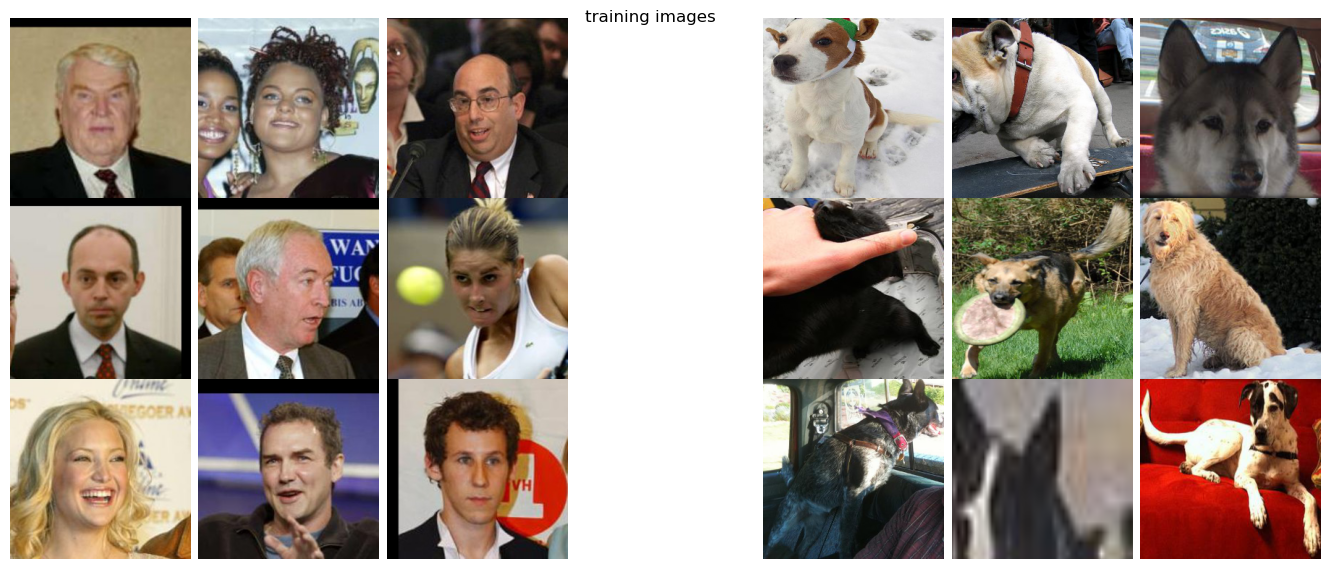

In [25]:
utils.plot_data_grid(positive_samples, negative_samples, title_string="training images")

In order to use the Viola-Jones face detector, we will rescale the images and convert them to greyscale. For this, we provide a preprocessing functions:

In [26]:
def greyscale_and_resize(images, img_dim=64):
    output_images = []
    for img in images:
        if len(img.shape)>2:
            grey_scale_img = np.mean(img, axis=2)
        else:
            grey_scale_img = img
        same_size_img = transform.resize(grey_scale_img, (img_dim, img_dim))
        output_images.append(same_size_img)
    return np.array(output_images)

In [27]:
def preprocess_images(images, img_dim=64, normalize=True):
    output_images = []
    for img in images:
        # Convert to grayscale if not already
        if len(img.shape) > 2:
            grey_scale_img = np.mean(img, axis=2)
        else:
            grey_scale_img = img

        # Resize to the target dimension
        resized_img = transform.resize(grey_scale_img, (img_dim, img_dim), anti_aliasing=True)

        # Normalize
        if normalize:
            resized_img = (resized_img - np.min(resized_img)) / (np.max(resized_img) - np.min(resized_img) + 1e-8)  # Avoid division by zero

        output_images.append(resized_img)

    return np.array(output_images)

Recall, the four feature templates considered in the Viola-Jones detector are the following, where the black bands are "positive" and the white bands "negative." Applying the feature involves computing the sum of the pixels in the black bands and then subtracting from that the sum of the pixels in the white bands.
![alt text](download.png)
<p> Image from: https://www.mygreatlearning.com/blog/viola-jones-algorithm/ </p>

To generate these, we will use the following helper classes, inspired by the ones in [this repository](https://github.com/salvacarrion/viola-jones).

In [28]:
# These classes adapted from https://github.com/salvacarrion/viola-jones
class Rectangle:
    def __init__(self, x, y, w, h):
        self.x = x
        self.y = y
        self.w = w
        self.h = h

    def compute_area(self, integral_img):
        '''
        integral_img is (n, dim, dim)
        '''
        a = (self.x-1, self.y-1)
        b = (self.x+self.w-1, self.y)
        c = (self.x, self.y+self.h-1)
        d = (self.x + self.w-1, self.y+self.h-1)
        n, sh1, sh2 = integral_img.shape
        if b[0] > sh2 or d[1] > sh1:
            print("Index Out of Bounds")
            return None
        return integral_img[:,d[1], d[0]] - integral_img[:,b[1], b[0]] - integral_img[:,c[1], c[0]] + integral_img[:,a[1], a[0]]

class HaarFeature:
    def __init__(self, pos, neg):
        self.positives = pos
        self.negatives = neg

    def compute_value(self, integral_img):
        positive_amt = np.sum(np.array([r.compute_area(integral_img) for r in self.positives]), axis=0)
        negative_amt = np.sum(np.array([r.compute_area(integral_img) for r in self.negatives]), axis=0)
        return positive_amt - negative_amt


We wish to apply these features at varying scales and locations within the image. Naively, computing the sum of the pixels in these regions might take up to $O(d^2)$ time, where $d$ is the dimension of the (square) image. One major innovation of the original paper was the idea of _integral images_ which allowed for computation of these features in constant time per feature.
![alt text](download-1.png)
<p>  Image from: https://towardsdatascience.com/the-intuition-behind-facial-detection-the-viola-jones-algorithm-29d9106b6999" </p>

In [29]:
def compute_integral_img(imgs):
    '''
    imgs is of shape (n, d_1, d_2)
    '''
    n, d_1, d_2 = imgs.shape
    integral_imgs = np.zeros((n, d_1, d_2))
    for i in range(d_1):
        integral_imgs[:, i, 0] = np.sum(imgs[:, :i+1, 0], axis = 1)
    for j in range(d_2):
        integral_imgs[:, 0, j] = np.sum(imgs[:, 0, :j+1], axis = 1)
    for i in range(1,d_1):
        for j in range(1,d_2):
            integral_imgs[:, i, j] = imgs[:, i, j] + integral_imgs[:, i, j-1] + integral_imgs[:, i-1, j] - integral_imgs[:, i-1, j-1]
    return integral_imgs

In [30]:
## apply preprocessing steps
phi_X = compute_integral_img(preprocess_images(X_train, img_dim=24,normalize=True))
y_train = np.array(y_train)

Next, we must compute the features from the template features described above. Below, we provide a function to compute the features across the whole image. Note that this function has optional parameters `stride` and `scale_stride` that limit the set of features we compute. `stride` refers to horizontal translation, and `scale_stride` refers to the difference between successive scalings.

This function does not `return` anything -- it only `yields`. Why is that? The object this contructs is called a [generator](https://wiki.python.org/moin/Generators). Generators allow us to build an iterator without explicitly instantiating all of it, thereby taking up memory. Here, we use a generator so that we can process each feature progressively but do not need to store them all in memory at once.

In [31]:
def feature_generator(img_dim, base_size=(5,5), scale_stride=1, stride=1):
    scales = np.arange(1, img_dim//min(base_size), scale_stride)
    for x_s in scales:
        for y_s in scales:
            start_pts_x = np.arange(0, img_dim, stride, dtype=int)
            start_pts_y = np.arange(0, img_dim, stride, dtype=int)
            for x in start_pts_x:
                for y in start_pts_y:
                    features_to_yield = []
                    w = x_s * base_size[1]
                    h = y_s * base_size[0]
                    if x + 2*w > img_dim or y + 2*h > img_dim:
                        break
                    else:
                        r1 = Rectangle(x, y, w, h)
                        r2 = Rectangle(x+w, y, w, h)
                        features_to_yield.append(HaarFeature([r2], [r1]))

                        r3 = Rectangle(x, y+h, w, h)
                        features_to_yield.append(HaarFeature([r3], [r1]))

                        r4 = Rectangle(x+w, y+h, w, h)
                        features_to_yield.append(HaarFeature([r2, r3], [r1, r4]))

                    if x+3*w > img_dim:
                        break
                    else:
                        r1 = Rectangle(x, y, w, h)
                        r2 = Rectangle(x+w, y, w, h)
                        r5 = Rectangle(x+2*w, y, w, h)

                        features_to_yield.append(HaarFeature([r2], [r1, r5]))
                    yield features_to_yield

With all these necessary pieces implemented, let us finally implement the Viola-Jones weak classifier.

In [35]:
class V_J_weak:
    def __init__(self, ft_stride=5, scale_stride=10):
        '''
        X is the set integral images
        '''
        self.feature = None
        self.T = 0
        self.stride = ft_stride
        self.scale_stride = scale_stride
        self.score = 0

    def fit(self, X, y, sample_weight=None):
        n, img_dim, _ = X.shape
        feature_gen = feature_generator(img_dim, scale_stride=self.scale_stride, stride=self.stride)
        max_score = -np.inf
        best_feature = None
        if sample_weight is None:
            sample_weight = 1/n*np.ones(n)
        i = 0
        while True:
            i = i+1
            try:
                item = next(feature_gen)
            except:
                break
            for f in item:
                features = f.compute_value(X)
                pos_ft, pos_wt = features[y==1], sample_weight[y==1]
                neg_ft, neg_wt = features[y==-1], sample_weight[y==-1]
                T, s = find_and_score_threshold(pos_ft, neg_ft, pos_wt, neg_wt)
                if s > max_score:
                    max_score = s
                    best_feature = (f, T)
        self.feature, self.T = best_feature
        self.score = max_score
        return self

    def predict(self, X):
        return 2*(self.feature.compute_value(X) > self.T) - 1


def find_and_score_threshold(class_1, class_2, wt_pos, wt_neg):
    min_pt = min(min(class_1), min(class_2))
    max_pt = max(max(class_1), max(class_2))
    score = lambda T: (np.sum(np.multiply((class_1 > T), wt_pos)) + np.sum(np.multiply((class_2 < T),wt_neg)))/(np.sum(wt_pos) + np.sum(wt_neg))
    potential_ts = np.linspace(min_pt, max_pt, 1000)
    scored_ts = [score(t) for t in potential_ts]
    i = np.argmax(scored_ts)
    return potential_ts[i], scored_ts[i]

### [Task 2] Run Boosting on Viola-Jones Weak Classifiers
Equipped with all the code, run AdaBoost on Viola Jones weak classifiers. Try messing with strides and n_learners to get what you think is a "good" classifier. Do test the case both `stride = 1` and `scale_stride = 1`, and compare performance to larger values.

**Check yourself**: what are the largest values you can set these two parameters to? What are the largest sensible values you can set these parameters to?

Also, the `n_learners` in AdaBoost is really a hyperparameter, and you may consider tuning it. Remember to use everything things you know about validation and test sets!

Another important thing to consider is `img_dim` when you created `phi_X` which is the resolution of the original image you would work with. The higher resolution will achieve a better performance, however, it may be computationally expensive. Something like `img_dim=24` runs in under 15 mins, and gives a decent accuracy. But you may also explore increasing this further.


In [36]:
# TASK 2 CODE
boosted_clf_vj = AdaBoost(V_J_weak, n_learners=100, ft_stride=1, scale_stride=1)
boosted_clf_vj.fit(phi_X, y_train)
vj_train_err = utils.empirical_err(y_train, boosted_clf_vj.predict(phi_X))
# TASK 2 CODE

print(f'Train error: {vj_train_err*100:0.2f}%')

Train error: 5.94%


In [ ]:
# TASK 2 CODE
boosted_clf_vj_default = AdaBoost(V_J_weak, n_learners=50)
boosted_clf_vj_default.fit(phi_X, y_train)
vj_train_err_default = utils.empirical_err(y_train, boosted_clf_vj.predict(phi_X))
# TASK 2 CODE

print(f'Train error: {vj_train_err*100:0.2f}%')

Train error: 5.94%


In [63]:
clfs = {}
for ft_stride in [1, 3, 5]:
    for scale_stride in [1, 5, 10]:
        if (50, ft_stride, scale_stride) in clfs:
            continue
        clf = AdaBoost(V_J_weak, n_learners=50, ft_stride=ft_stride, scale_stride=scale_stride)
        clf.fit(phi_X, y_train)
        clfs[(50, ft_stride, scale_stride)] = clf

In [37]:
test_phi_X = compute_integral_img(preprocess_images(X_test, img_dim=24,normalize=True))
y_test = np.array(y_test)

In [64]:
for n_learners, ft_stride, scale_stride in clfs:
    clf = clfs[(n_learners, ft_stride, scale_stride)]
    yvj_test_predict = clf.predict(test_phi_X)
    vj_test_err = utils.empirical_err(y_test, yvj_test_predict)
    vj_train_err = utils.empirical_err(y_train, clf.predict(phi_X))
    print(f'Number of learners: {n_learners}, feature stride: {ft_stride}, scale stride: {scale_stride}')
    print(f'Train error : {vj_train_err*100:0.2f}%')
    print(f'Test error : {vj_test_err*100:0.2f}%')

Number of learners: 50, feature stride: 1, scale stride: 1
Train error : 10.43%
Test error : 19.61%
Number of learners: 50, feature stride: 1, scale stride: 5
Train error : 10.64%
Test error : 18.51%
Number of learners: 50, feature stride: 1, scale stride: 10
Train error : 10.64%
Test error : 18.51%
Number of learners: 50, feature stride: 3, scale stride: 1
Train error : 13.54%
Test error : 22.10%
Number of learners: 50, feature stride: 3, scale stride: 5
Train error : 13.88%
Test error : 23.20%
Number of learners: 50, feature stride: 3, scale stride: 10
Train error : 13.88%
Test error : 23.20%
Number of learners: 50, feature stride: 5, scale stride: 1
Train error : 19.27%
Test error : 25.41%
Number of learners: 50, feature stride: 5, scale stride: 5
Train error : 19.48%
Test error : 27.35%
Number of learners: 50, feature stride: 5, scale stride: 10
Train error : 19.48%
Test error : 27.35%


In [83]:
# best clfs is (50, 1, 5)
boosted_clf_vj = clfs[(50, 1, 5)]

### Investigate Boosted Predictor and its Constitutent Weak Predictors

To understand what is happening inside the Viola-Jones classifier using Boosting, let us examine the outputs of various weak classifiers at increasing "depths" and of the final boosted classifier to see where the respective classifiers fail.

To this end, we present two functions. The first extracts the indices on which a particular classifier succeeds and fails and use that to return the four different categories of images: faces where it failed, non-faces where it failed, faces where it succeeded, and non-faces where it suceeded. The other visualizes a subset of the images extracted in a grid for ease of inspection. **Be sure to visualize both the raw images and the `greyscale_and_resized` images -- that is, replace the third argument with the appropriate input.**

In [66]:
def extract_rights_wrongs(boosted_clf, processed_X_test, X_test, y_test, idx=None):
    '''
    could either have this fn only handle the weak classifiers, or just write
    one fn with idx as an optional arg, and if it is not received, it will just run clf.predict

    takes in processed Xs for inference but also raw Xs to output
    '''
    if idx is not None:
        clf = boosted_clf.learned_clfs[idx]
    else:
        clf = boosted_clf
    pred = clf.predict(processed_X_test)
    wrong_idxs = np.where(np.not_equal(pred, y_test))[0]
    right_idxs = np.where(np.equal(pred, y_test))[0]
    class_1_incorrect = [X_test[i] for i in wrong_idxs if y_test[i]==1]
    class_0_incorrect = [X_test[i] for i in wrong_idxs if y_test[i]==-1]
    class_1_correct = [X_test[i] for i in right_idxs if y_test[i]==1]
    class_0_correct = [X_test[i] for i in right_idxs if y_test[i]==-1]
    return class_1_incorrect, class_0_incorrect, class_1_correct, class_0_correct

In [77]:
def plot_confusion_grid(wrong_faces, wrong_notfaces, right_faces, right_notfaces, title_string, cmap = 'viridis'):
    f, axarr = plt.subplots(5,7, figsize=(14,10))#, gridspec_kw={'hspace': 0.1})
    f.tight_layout()
    for i in range(5):
        for j in range(7):
            try:
                if j < 3:
                    if i < 2:
                        axarr[i,j].imshow(wrong_faces[i*3 + j], cmap = cmap)# , aspect = "auto")
                    if i > 2:
                        axarr[i, j].imshow(wrong_notfaces[(i-3)*3 + j], cmap = cmap)
                elif j == 3:
                    axarr[i,j].imshow(np.ones((2,2,3)))# , aspect = "auto")
                elif j > 3:
                    if i < 2:
                        axarr[i,j].imshow(right_faces[i*3 + j-4], cmap = cmap)
                    if i > 2:
                        axarr[i,j].imshow(right_notfaces[(i-3)*3 + j - 4], cmap = cmap)
            except:
                axarr[i,j].imshow(np.ones((2,2,3)))
            axarr[i,j].axis('off')
    f.subplots_adjust(hspace=0.0, wspace=0.0)#, right=0.7)

    f.suptitle(title_string, y=1.02, size=20)
    axarr[0,1].set_title("GOT WRONG", size=16)
    axarr[0,5].set_title("GOT RIGHT", size=16)
    plt.show()

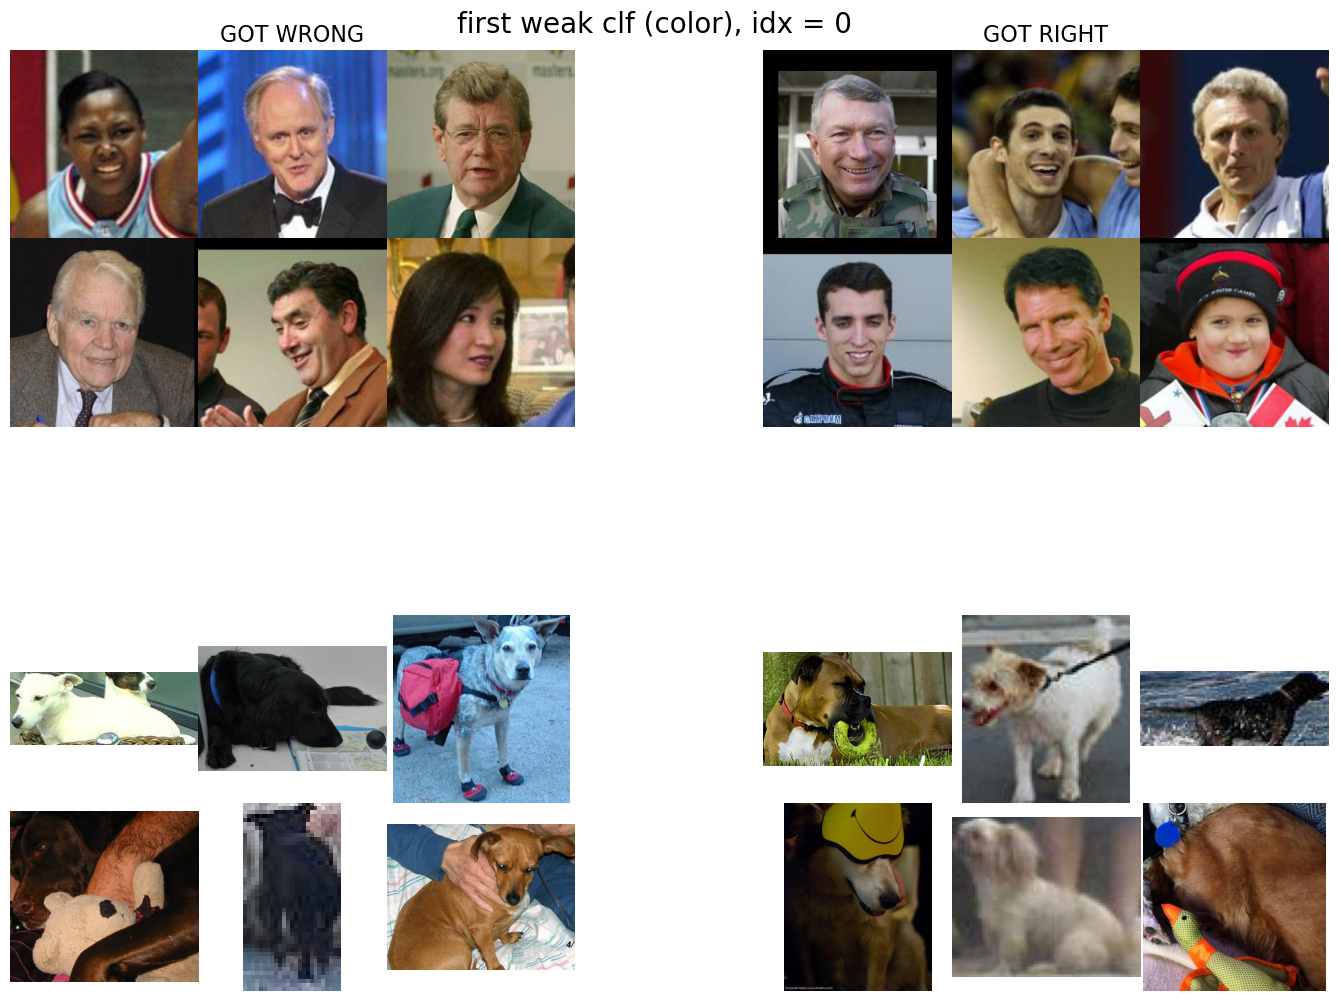

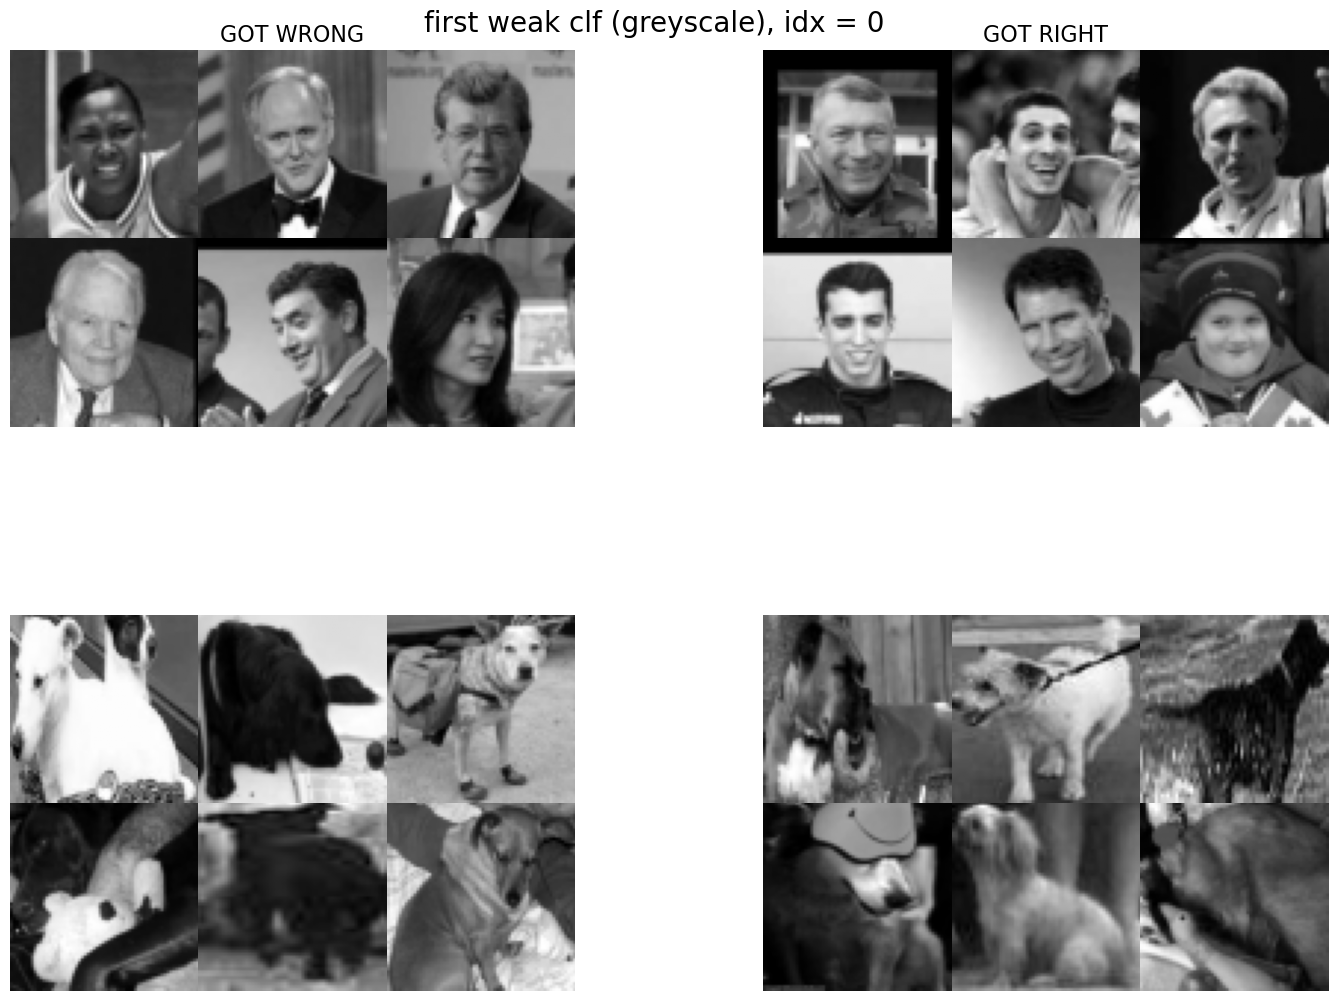

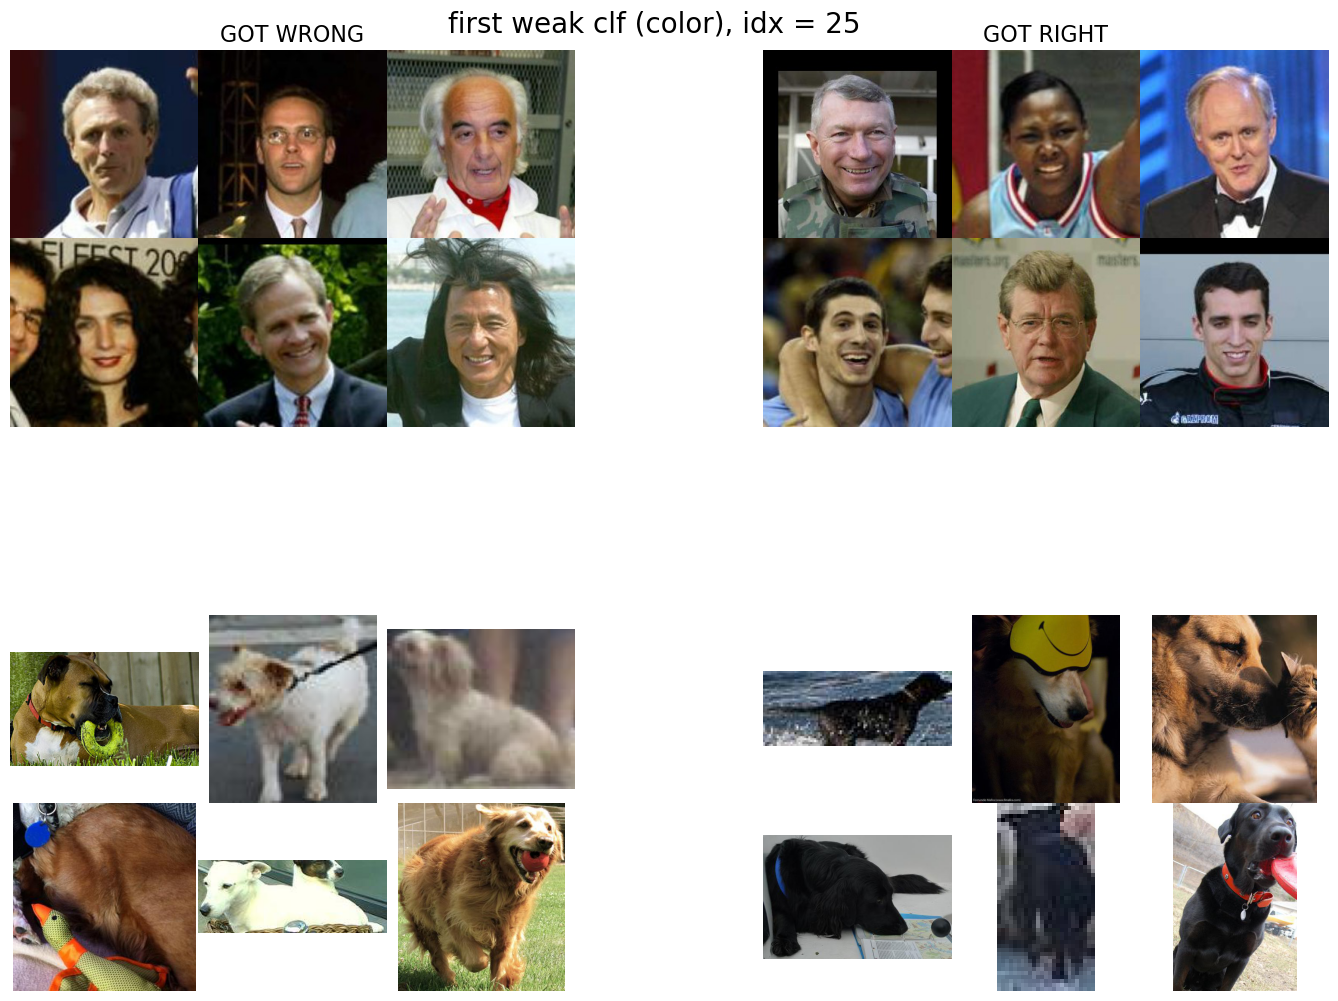

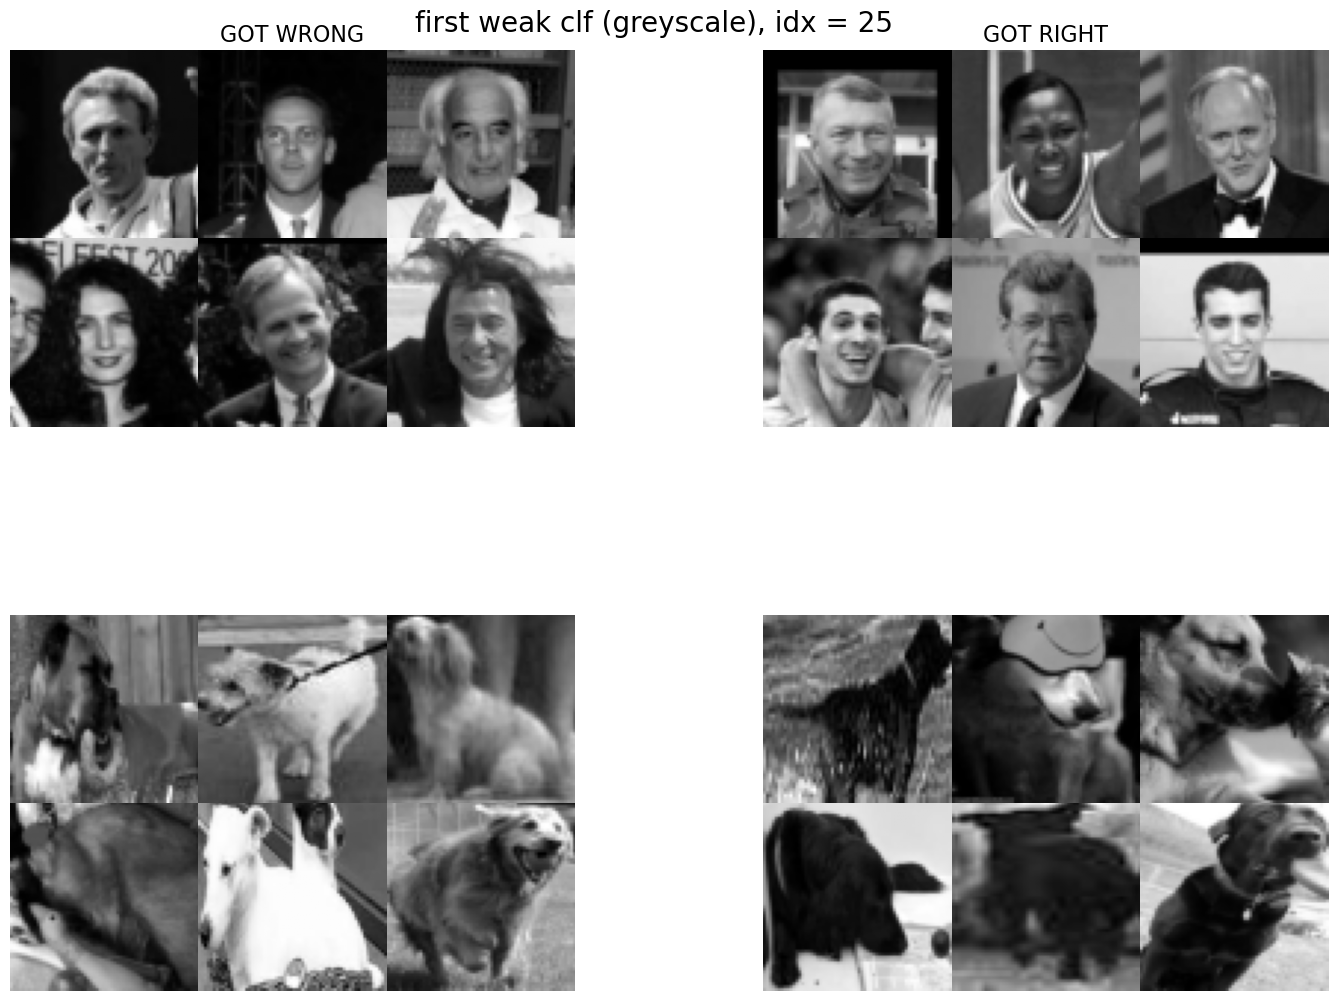

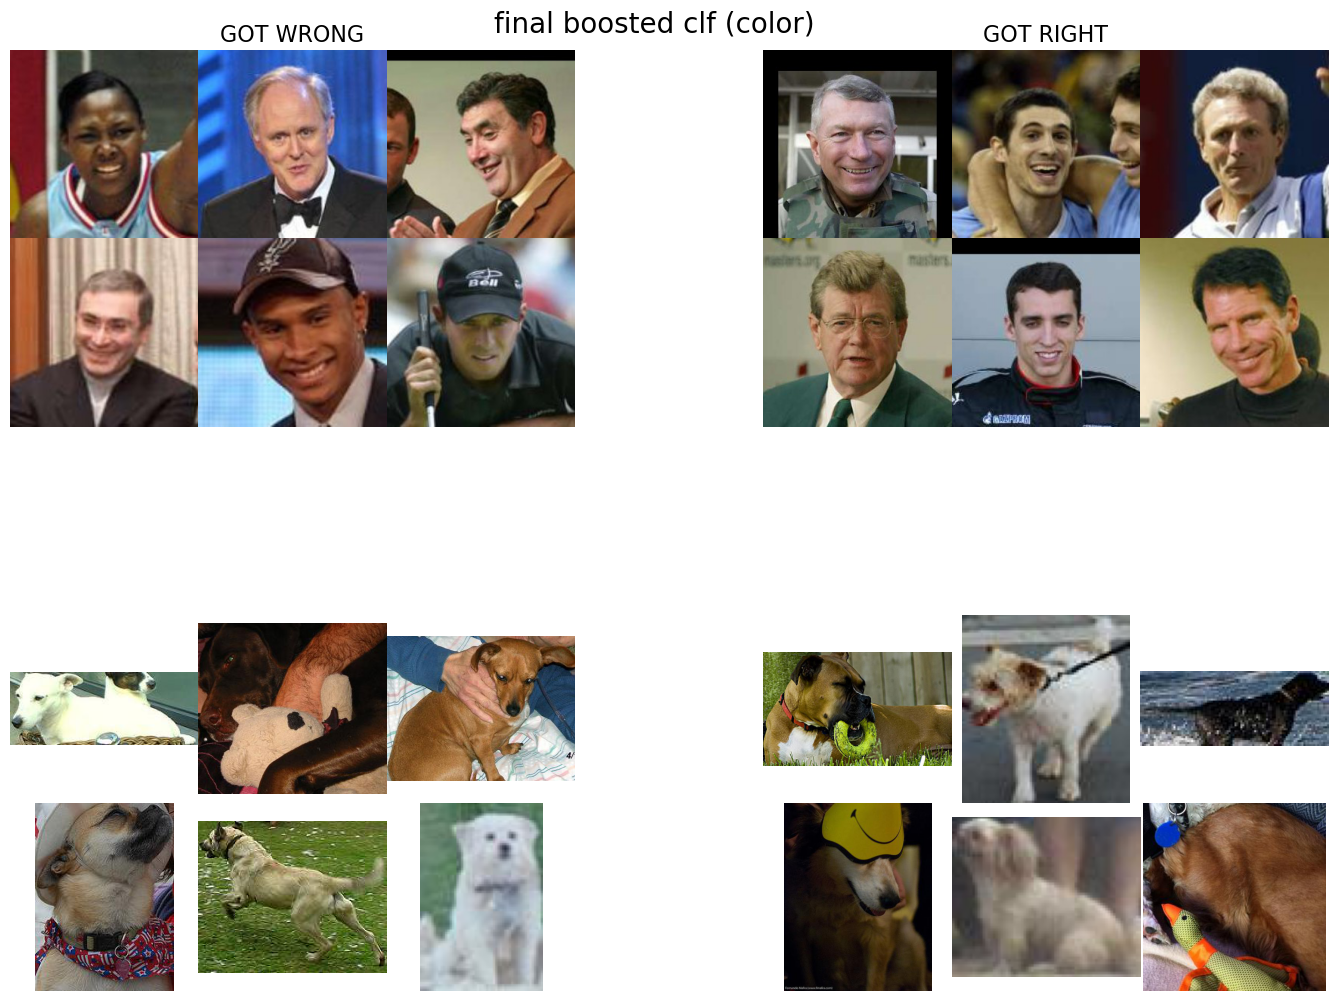

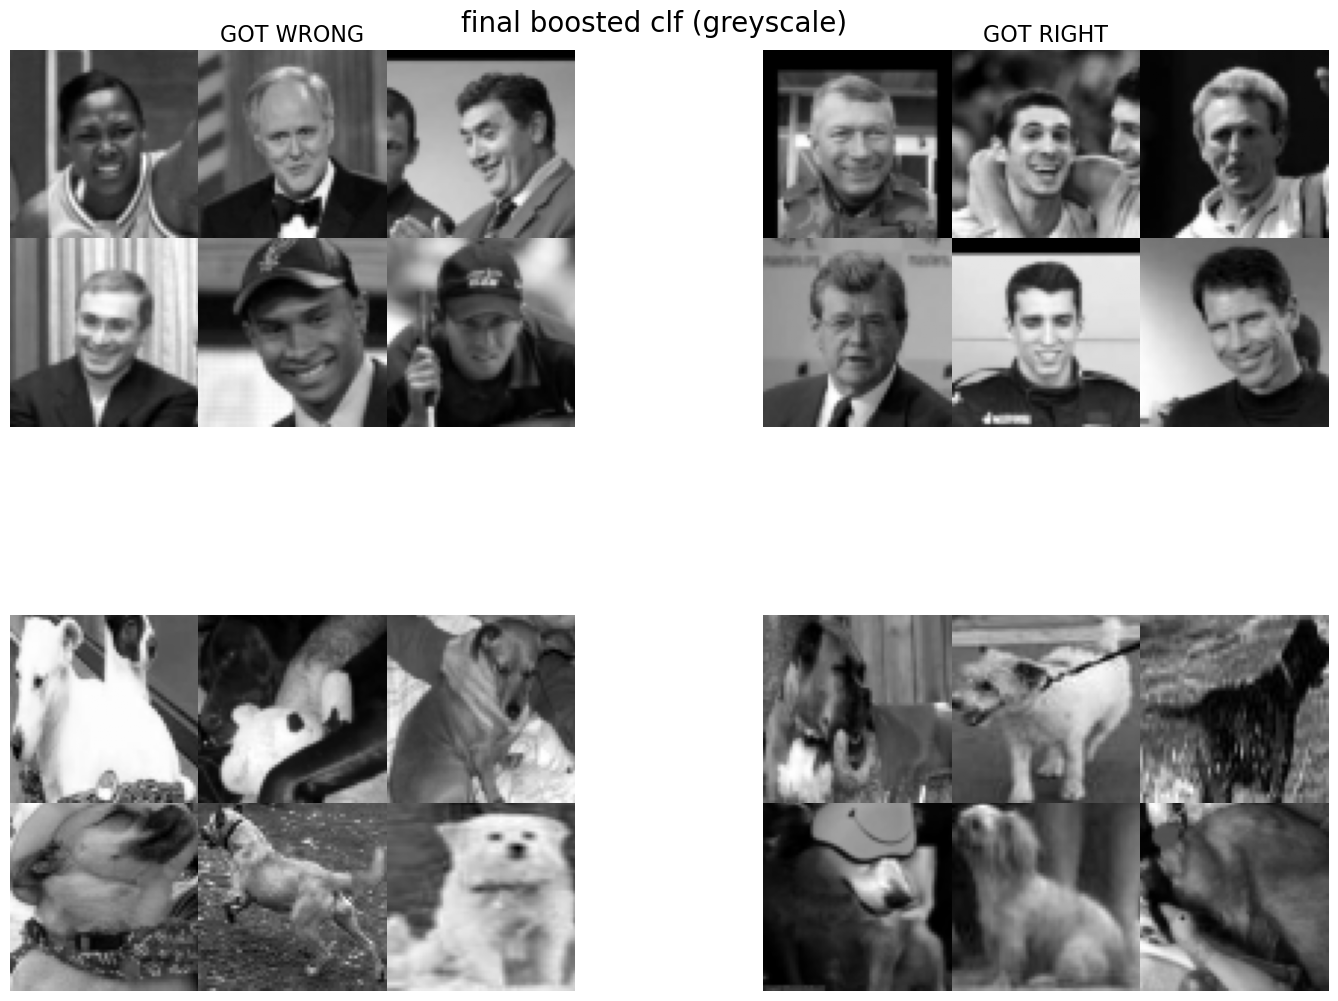

In [87]:
plot_confusion_grid(*extract_rights_wrongs(boosted_clf_vj, test_phi_X, X_test, y_test, idx=0), "first weak clf (color), idx = 0")
plot_confusion_grid(*extract_rights_wrongs(boosted_clf_vj, test_phi_X, preprocess_images(X_test), y_test, idx=0), "first weak clf (greyscale), idx = 0", cmap = 'gray')
plot_confusion_grid(*extract_rights_wrongs(boosted_clf_vj, test_phi_X, X_test, y_test, idx=25), "first weak clf (color), idx = 25")
plot_confusion_grid(*extract_rights_wrongs(boosted_clf_vj, test_phi_X, preprocess_images(X_test), y_test, idx=25), "first weak clf (greyscale), idx = 25", cmap = 'gray')
plot_confusion_grid(*extract_rights_wrongs(boosted_clf_vj, test_phi_X, X_test, y_test), "final boosted clf (color)")
plot_confusion_grid(*extract_rights_wrongs(boosted_clf_vj, test_phi_X, preprocess_images(X_test), y_test), "final boosted clf (greyscale)", cmap = 'gray')

<span style="color: red">
<h4 style="font-weight: bold">[Answer Question 1]</h4>

* For some of the weak classifiers, visualize some images on which it is quite discriminative and others on which it is not. Do you notice any trends?

* What examples does the final boosted classifier succeed and fail on?

Address these questions in 2-3 bullet points.

<h4 style="font-weight: bold">---------------------</h4>

<span style="color: blue">
Answer: 

* The initial weak classifiers seem to do better on people who are not wearing suits, and the later ones do better with suits, but only suits with ties. 

* The final boosted classifier fails on people and dogs that are wearing hats. Additionally, there is one dog that the boosted classifier that fails on that has a human hand in it. The boosted classifier correctly classifies the dog on a leash. The other examples are not really interpretable. 
</span>

<h4 style="font-weight: bold">---------------------</h4>
</span>

<span style="color: red">
<h4 style="font-weight: bold">[Answer Question 2]</h4>

Finally, now that you've explored the model quite a bit, reflect on some limitations of this approach, both technically and practically. A couple of bullet points suffice.

<h4 style="font-weight: bold">---------------------</h4>

<span style="color: blue">
Answer:

* The model has very many parameters, n_learners, ft_stride, scale_stride, base_size, img_dim, and there could be more included. Selecting some of these features makes training take *very* long. For instance, I accidentally increased n_learners from 50 to 100, and the training took an hour. With this many parameters, tuning for a good predictor should take incredibly long. 

* It's difficult to see what the model is getting wrong from the examples. The model is not very interpretable. 

* It's hard to interpret the features the model uses, or know that the right ones were used.
</span>

<h4 style="font-weight: bold">---------------------</h4>
</span>